In [23]:
# SETUP
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(12345)

# true parameters
w_true = 1/3
mu1_true, mu2_true = 1.0, 3.0
sigma1_true, sigma2_true = 1.0, 2.0
N = 1000


In [24]:
# SIMULATE SAMPLES
def simulate_p(N, w, mu1, mu2, sigma1, sigma2, rng):
    z = rng.random(N) < w            
    x = np.empty(N)
    x[z]  = rng.normal(mu1, sigma1, size=z.sum())
    x[~z] = rng.normal(mu2, sigma2, size=(~z).sum())
    return x

x = simulate_p(N, w_true, mu1_true, mu2_true, sigma1_true, sigma2_true, rng)


In [29]:
def normal_pdf(x, mu, sigma):
    return (1.0 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)

# THE EM ALGORITHM
def em_gmm_1d(x, n_iter:5000, seed=42):
    rng = np.random.default_rng(seed)
    N = len(x)

    # set the initial means to two randomly chosen samples 
    a, b = rng.choice(x, size=2, replace=False)
    mu1, mu2 = min(a, b), max(a, b)

    # set the initial std deviations to the sample std deviation
    s = np.std(x)
    sigma1, sigma2 = s,s

    # set the initial weight
    w = 0.5

    # record parameters in history for plotting convergence later if I have time
    history = {"w":[w], "mu1":[mu1], "mu2":[mu2], "sigma1":[sigma1], "sigma2":[sigma2]}

    for _ in range(n_iter):
        # E step
        p1 = w * normal_pdf(x, mu1, sigma1)
        p2 = (1 - w) * normal_pdf(x, mu2, sigma2)
        r1 = p1 / (p1 + p2)   
        r2 = 1 - r1

        # M step
        Nk1, Nk2 = r1.sum(), r2.sum()
        mu1 = (r1 @ x) / Nk1
        mu2 = (r2 @ x) / Nk2
        sigma1 = np.sqrt((r1 @ (x - mu1)**2) / Nk1)
        sigma2 = np.sqrt((r2 @ (x - mu2)**2) / Nk2)
        w = Nk1 / N


        # update the history
        history["w"].append(w)
        history["mu1"].append(mu1)
        history["mu2"].append(mu2)
        history["sigma1"].append(sigma1)
        history["sigma2"].append(sigma2)

    return {"w": w, "mu1": mu1, "mu2": mu2, "sigma1": sigma1, "sigma2": sigma2, "history": history}


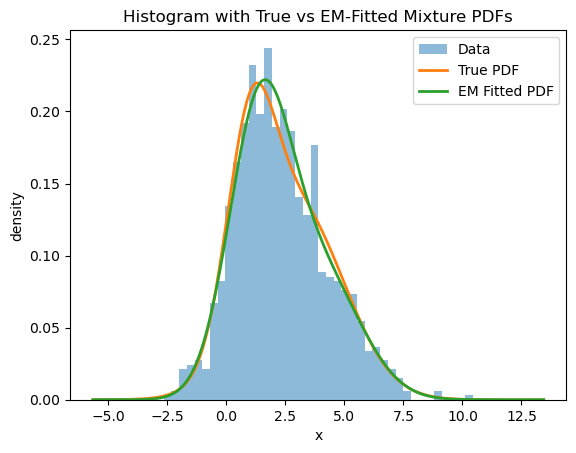

Final parameter differences (true − estimate):
param            true     estimate           diff
w            0.333333     0.629687      -0.296353
mu1          1.000000     1.392692      -0.392692
mu2          3.000000     3.965276      -0.965276
sigma1       1.000000     1.317881      -0.317881
sigma2       2.000000     1.738455      +0.261545


In [30]:
est = em_gmm_1d(x=x, n_iter=500,seed=238570)

# PLOTTING AND RESULTS

xs = np.linspace(min(x)-3, max(x)+3, 400)

true_pdf = (w_true * normal_pdf(xs, mu1_true, sigma1_true)
            + (1 - w_true) * normal_pdf(xs, mu2_true, sigma2_true))

fitted_pdf = (est["w"] * normal_pdf(xs, est["mu1"], est["sigma1"])
              + (1 - est["w"]) * normal_pdf(xs, est["mu2"], est["sigma2"]))

plt.figure()
plt.hist(x, bins=40, density=True, alpha=0.5, label="Data")
plt.plot(xs, true_pdf, linewidth=2, label="True PDF")
plt.plot(xs, fitted_pdf, linewidth=2, label="EM Fitted PDF")
plt.title("Histogram with True vs EM-Fitted Mixture PDFs")
plt.xlabel("x"); plt.ylabel("density")
plt.legend()
plt.show()

# table of final differences
hist = est["history"]

w_hat      = hist["w"][-1]
mu1_hat    = hist["mu1"][-1]
mu2_hat    = hist["mu2"][-1]
sigma1_hat = hist["sigma1"][-1]
sigma2_hat = hist["sigma2"][-1]

final_rows = [
    ("w",      w_true,      w_hat,       w_true      - w_hat),
    ("mu1",    mu1_true,    mu1_hat,     mu1_true    - mu1_hat),
    ("mu2",    mu2_true,    mu2_hat,     mu2_true    - mu2_hat),
    ("sigma1", sigma1_true, sigma1_hat,  sigma1_true - sigma1_hat),
    ("sigma2", sigma2_true, sigma2_hat,  sigma2_true - sigma2_hat),
]

print("Final parameter differences (true − estimate):")
print("{:<8s} {:>12s} {:>12s} {:>14s}".format("param", "true", "estimate", "diff"))
for name, t, e, d in final_rows:
    print("{:<8s} {:>12.6f} {:>12.6f} {:>+14.6f}".format(name, t, e, d))


These final differences seem underwhelming. I don't know why the convergence isn't better, I played around with the number of iterations a lot and it didn't do much... 